# Магнитное поле в веществе

Определить поля вектора магнитной индукции $\vec{B}$ и вектора напряжённости магнитного поля $\vec{H}$ внутри и вне цилиндра длиной $l$ и радиусом $a$ с замороженной намагниченностью $\vec{M}$, параллельной оси цилиндра.

![схема](pics/magnet.png)

Намагниченность цилиндра по-определению равна
$$\vec{M} = \frac{\vec{p_m}}{V}$$
где $\vec{p_m}$ — вектор магнитного момента, $V$ — объём цилиндра.

В рамках модели Ампера намагниченность постоянного магнита эквивалентна создаваемой электромагнитом, по боковой поверхности которого по кругу течёт ток намагничивания $I_m$, поэтому магнитный момент цилиндра
$$\vec{p_m} = I_m S \vec{n}, \;V = S\,l,$$
где $S$ — площадь плоскости элементарного контура, т.е. торца цилиндра.

Отсюда ток намагничивания: $$I_m = l\,M.$$

Вектор магнитной индукции $d\vec{B}$ в точке на расстоянии $\vec{r^\prime}$ от элемента тока намагничивания $\vec{dI_m} = dI_m\,d\vec{l}$ с координатами $(x_0,y_0,z_0)$ по закону Био - Савара - Лапласа определяется как
$$d\vec{B} = \frac{\mu_0}{4\pi} \frac{dI_m \,\left[ d\vec{l} \times \vec{r^\prime} \right] }{\left| \vec{r^\prime} \right|^3},$$
где элемент тока
$$dI_m = I_m\frac{dz_0}{l} = M\,dz_0,$$
вектор-элемент контура
$$d\vec{l} = \left\{ -a\,d\varphi\,\sin\varphi, \;a\,d\varphi\,\cos\varphi, \;0  \right\},$$
вектор, направленный от элемента тока в точку наблюдения, 
$$\vec{r^\prime} = \left\{ x - x_0, y - y_0, z - z_0 \right\} = \left\{ x - a\,\cos\varphi, \;y - a\,\sin\varphi, \;z - z_0\right\},$$
а их векторное произведение
$$\left[ d\vec{l} \times \vec{r^\prime} \right] = \hat{\vec{q}}\,a\,d\varphi,\; \hat{\vec{q}} = \left\{ \cos\varphi\,(z-z_0), \;\sin\varphi\,(z-z_0), \;-\sin\varphi(y-a\sin\varphi)-\cos\varphi(x-a\cos\varphi)\right\}.$$
Здесь учтено, что ось магнитного цилиндра совпадает с осью $z$.

Тогда вектор магнитной индукции от всего цилиндрического магнита рассчитывается как
$$\vec{B}(x,y,z) = \iiint d\vec{H} = \frac{\mu_0\,M\,a}{4\pi} \int_0^l dz_0 \int_0^{2\pi} \frac{ \hat{\vec{q}} d\varphi}{ \left| \vec{r^\prime} \right|^3 }.$$

Наконец, вектор напряжённости магнитного поля $\vec{H}$ внутри цилиндрического магнита по-определению равен
$$\vec{H} = \frac{\vec{B}}{\mu_0} - \vec{M},$$
а вне магнита
$$\vec{H} = \frac{\vec{B}}{\mu_0}.$$

## Постановка вычислительной задачи

Начнём с импорта необходимых библиотек: `NumPy` для работы с массивами, `SciPy` для численного интегрирования, `tqdm` для отображения индикатора выполнения (прогресс-бара).

In [1]:
import numpy as np
import scipy.integrate

from tqdm import tqdm

Зададим конкретные численные значения для констант, входящих в задачу: намагниченность $M$, длина и радиус магнита $l, a$.

In [2]:
M = 20000 # А/м
l = 0.02  # м
a = 0.005 # м

mu0 = 1.2566e-6 # Н/м, магнитная постоянная

Определим функции, возвращающие компоненты вектора магнитной индукции $\vec{B}$. При этом воспользуемся методом `scipy.integrate.dblquad()` (double quadrature) для численного расчёта двойного определённого интеграла. Следует обратить внимание, что в `dblquad()` предполагается, что интегрируемая функция $f$ от двух переменных принимает их в порядке $f(\xi_2, \xi_1)$.

In [3]:
def dB_xyz(x,y,z):
    """
    3 компонента подинтегральной функции для расчёта вектора магнитной индукции

    Args:
        x,y,z (float): координаты точек наблюдения.

    Returns:
        tuple of functions: функции для расчёта dHx, dHy, dHz.
    """

    def r3(z0,phi):
        r = np.sqrt( (x - a*np.cos(phi))**2 + (y - a*np.sin(phi))**2 + (z - z0)**2 )
        return r*r*r
    
    # NB: Порядок аргументов у функций!
    return \
        lambda phi,z0: np.cos(phi)*(z - z0) / r3(z0,phi), \
        lambda phi,z0: np.sin(phi)*(z - z0) / r3(z0,phi), \
        lambda phi,z0: -( np.sin(phi)*(y - a*np.sin(phi)) + np.cos(phi)*(x - a*np.cos(phi)) ) / r3(z0,phi)

def getB_xyz(XYZ):
    """
    3 компонента вектора магнитной индукции

    Args:
        XYZ (4D ndarray): координаты точек наблюдения.

    Returns:
        tuple of ndarrays: компоненты Bx, By, Bz.
    """
    nx, ny, nz, nf = XYZ.shape
    
    progressbar = tqdm(total=nx*ny*nz*nf, ncols=80)
    
    _b = np.empty_like( XYZ )
    for k in range(0,nz):
        for j in range(0,ny):
            for i in range(0,nx):
                x, y, z = XYZ[i,j,k,:]
                dB = dB_xyz(x,y,z) # предвычисленная функция от (phi, z0) в данной точке (x,y,z)

                for f in range(nf):
                    res = scipy.integrate.dblquad( 
                        dB[f],  # подинтегральная функция, должна принимать аргументы в порядке (phi, z0) 
                        0, # нижний предел интегрирования по первой переменной `z0`
                        l, # верхний предел интегрирования по первой переменной `z0`
                        lambda z0: 0,      # нижний предел интегрирования по второй переменной `phi` как функция от `z0`
                        lambda z0: 2*np.pi # верхний предел интегрирования по второй переменной `phi` как функция от `z0`
                    )
                    _b[i,j,k, f] = res[0]
                    progressbar.update(1)
    progressbar.close()                    
    
    return _b * mu0*M*a/4/np.pi

Определим функцию для расчёта вектора напряжённости магнитного поля $\vec{H}(x,y,z)$ на основе предварительно вычисленного поля магнитной индукции

In [4]:
def getH_xyz( XYZ, B_xyz ):
    """
    3 компонента вектора напряжённости магнитного поля

    Args:
        XYZ (4D ndarray): координаты точек наблюдения.
        B_xyz (4D ndarray): компоненты вектора магнитной индукции

    Returns:
        tuple of ndarrays: компоненты Hx, Hy, Hz.
    """
    vM = np.array( [0,0,M] ) # вектор намагниченности

    # Точка наблюдения внутри магнита?
    def is_inside(x,y,z):
        return x**2 + y**2 <= a**2 and z >= 0 and z <= l
    
    nx, ny, nz, nf = XYZ.shape
    _H = np.empty_like( XYZ )
    for k in range(0,nz):
        for j in range(0,ny):
            for i in range(0,nx):
                x, y, z = XYZ[i,j,k,:]
                B = B_xyz[i,j,k]

                _H[i,j,k] = B/mu0 - vM if is_inside(x,y,z) else B/mu0

    return _H

### Расчётная сетка

Очевидно задача имеет осевую симметрию, поэтому, не нарушая общности, можно проводить расчёты в плоскости $(x,z)$ при $y=0$.

Определим формально трёхмерную, но фактически двухмерную, декартову сетку, состоящую из равномерно распределённых узлов. В качестве расчётной области выберем прямоугольник со сторонами $x,y,z \in \left[-0.03,0.03\right], 0, \left[0,0.05\right]$. Границы расчетной области обозначим переменными `{x,y,z}_start` и `{x,y,z}_end`, а число узлов вдоль каждого направления — `grid_N{x,y,z}`.

Сетка создаётся с помощью специального объекта `numpy.mgrid[start:end:step,...]`, который генерирует координаты узлов с равномерным распределением от `start` до `end` с шагом `step`. Причём eсли `step = N*1j` (мнимая комплексная величина), то он определяется числом точек разбиения `N`.

Координаты сеточных узлов хранятся в 4х-мерном массиве `grid_XYZ` размерностью `(Nx, Ny, Nz, 3)`, где `N*` — число узлов вдоль каждого направления, 3 — число значений в каждом узле (координаты $x$, $y$ и $z$).

In [5]:
# Границы расчётной области
x_start, x_end =  -0.02,  0.02            
y_start, y_end =  0.00,  0.00
z_start, z_end =  -0.01, 0.04

# Число узлов сетки в каждом направлении
grid_Nx, grid_Ny, grid_Nz = 21, 1, 31

def make_grid():
    # 1D массивы координат узлов сетки
    xx = np.linspace(x_start, x_end, grid_Nx)
    yy = np.linspace(y_start, y_end, grid_Ny)
    zz = np.linspace(z_start, z_end, grid_Nz)
    
    # 3D массивы координат узлов сетки
    # NB: последовательность
    X, Y, Z = np.meshgrid(xx,yy,zz, indexing='ij')

    # Объединённый 4D массив координат: [ {x0,y0,z0}, {x1,y1,z1}, ... ]
    return np.stack( (X, Y, Z), axis=3 )

grid_XYZ = make_grid()
print( 'Размерность сетки: ', grid_XYZ.shape )

Размерность сетки:  (21, 1, 31, 3)


### Расчёт магнитного поля

Выполним расчёт поля магнитной индукции $\vec{B}(x,y,z)$ в узлах сетки. Вычисления не оптимизированы и в зависимости от мелкости разбиения могут продолжаться заметное время.

In [6]:
# Длительная функция численного интегрирования
Bxyz = getB_xyz(grid_XYZ)

# Абсолютное значение вектора магнитной индукции
absB = np.sqrt( Bxyz[:,:,:, 0]**2 + Bxyz[:,:,:, 1]**2 + Bxyz[:,:,:, 2]**2 )

100%|███████████████████████████████████████| 1953/1953 [03:06<00:00, 10.45it/s]


На основе поля магнитной индукции вычислим поле напряжённости индукции $\vec{H}(x,y,z)$ в узлах сетки:

In [7]:
Hxyz = getH_xyz(grid_XYZ, Bxyz)

# Абсолютное значение вектора напряжённости магнитного поля
absH = np.sqrt( Hxyz[:,:,:, 0]**2 + Hxyz[:,:,:, 1]**2 + Hxyz[:,:,:, 2]**2 )

## Визуализация

Как обычно для построения графиков воспользуемся библиотекой `MatplotLib`. Дополнительно потребуется `matplotlib.patches` для рисования фигуры магнита поверх графика.

In [8]:
# отображение графиков внутри блокнота (вызывать ПЕРЕД импортом библиотеки)
%matplotlib inline
import matplotlib.pyplot as plt

# Рисование поверх графиков
import matplotlib.patches as pltpatches

Для визуализации полученного решения построим поле абсолютного значения $\left|\vec{B}\right|$ с помощью `matplotlib.contourf()`, а также векторное поле $\vec{B}$ в плоскости $(x,z)$ с помощью `matplotlib.streamplot()`. При этом на контурном графике используем увеличенное число цветовых уровней. Для наглядности отобразим поверх графика изображение контуров магнита с помощью `matplotlib.patches.Rectangle`.

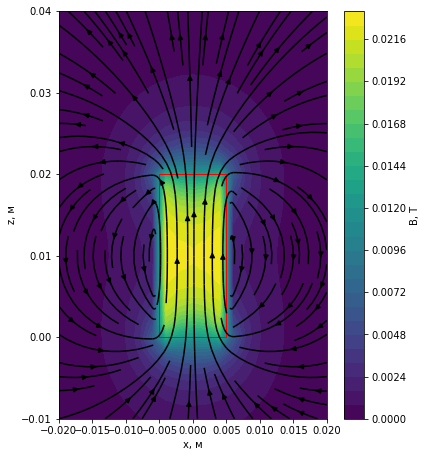

In [10]:
# Двухмерные поля в плоскости (x,z)
# NB: Используется транспонирование для соответствия `contourf`
X,  Z  = grid_XYZ[:,0,:, 0].T,  grid_XYZ[:,0,:, 2].T
Bx, Bz =    Bxyz[:,0,:, 0].T,      Bxyz[:,0,:, 2].T
aB     = absB[:,0,:].T

size = 6
plt.figure(figsize=(size, (z_end-z_start)/(x_end-x_start)*size))

plt.xlabel('x, м')
plt.ylabel('z, м')

# Контурный график
figC = plt.contourf(X, Z, aB, 30)
cbar = plt.colorbar(figC)
cbar.ax.set_ylabel('B, Т')

# Векторное поле
figV = plt.streamplot(X,Z, Bx,Bz, color='k')

# Магнит
plt.gca().add_patch(pltpatches.Rectangle((-a,0), 2*a, l, edgecolor='r', facecolor='none'))

plt.show()

Аналогичные графики построим для напряжённости магнитного поля $\vec{H}(x,y,z)$.

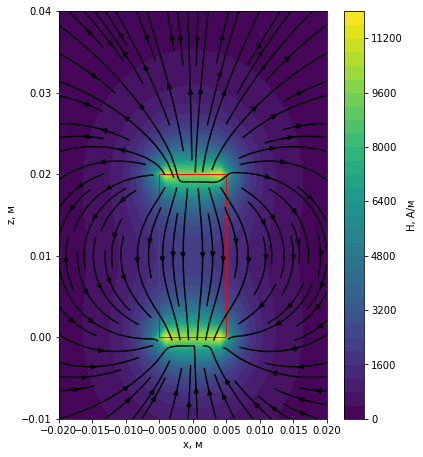

In [9]:
# Двухмерные поля в плоскости (x,z)
# NB: Используется транспонирование для соответствия `contourf`
X,  Z  = grid_XYZ[:,0,:, 0].T,  grid_XYZ[:,0,:, 2].T
Hx, Hz  =    Hxyz[:,0,:, 0].T,      Hxyz[:,0,:, 2].T
aH      = absH[:,0,:].T

size = 6
plt.figure(figsize=(size, (z_end-z_start)/(x_end-x_start)*size))

plt.xlabel('x, м')
plt.ylabel('z, м')

# Контурный график
figC = plt.contourf(X, Z, aH, 30)
cbar = plt.colorbar(figC)
cbar.ax.set_ylabel('H, A/м')

# Векторное поле
figV = plt.streamplot(X,Z, Hx,Hz, color='k')

# Границы магнита
plt.gca().add_patch(pltpatches.Rectangle((-a,0), 2*a, l, edgecolor='r', facecolor='none'))

plt.show()